# This is a preliminary model construct
based on the model from my master thesis _(a droop quota batch culture model)_ i designed this code to test some ideas that have been brewing in my head these last few weeks. It is as of yet a very rough product.. just a sketch of the model that I am aiming for, but the general idea behind it is there.  

  
# The idea
the idea behind it is to construct a model based on classes of the components (here it is simply phytoplankton, but this will be extened to the different functional groups, zooplankton, nutrients and the external forcing). It follows an object oriented programming structure to allow for a modular modeling framework, where diversity can be easily controlled and changed.  
  
The goal is to produce a python package (relatively easy to implement from the start using basic OOP structure):
- that can read a csv file as "setup instructions", which include number and parametrisations of functional types & subtypes
- through list comprehensions, subclasses and dictionaries any type of structure can be implemented within the model function definition *f(y,t)*
- the model is solved using odeint
- output is plotted automatically using the same modular extensible structure
  
All basic components are present here, however there are a few important points missing, to which you can perhaps give feedback or add... :
- a dictionary setup for all the model parameters, simplifying initalisation and calling functions within model definition function
- external forcings
- more complex model setup (for this most functions will be hidden in classes and called within list comprehensions in the model definition function
- OOP structure for nutrients, allowing for addition of more (e.g. silicate)
- ....

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

# a very rudimentary phytoplankton class
which will have to be greatly extended, and can include different growth formulations, which the model can be run with...   
in the future it could also inherit from a "population" class and share this with another Zooplankton class.. however this might not be necessary

In [2]:
class Phytoplankton():
    
        
    def __init__(self, mu8, M):
        
        self.mu8 = mu8 # mu8 = unlimited growth rate (at replete nut)
        self.m = M # m = mortality (specific) [/d]

    def growth(self, Q, cellnum, Qmin):
        """Droop Model of Phytoplankton Growth"""

        # Q = internal nut Quota [µmol/cell]
        # Qmin = minimum internal nut conc. [µmol/cell]
        # mu8 = unlimited growth rate (at replete nut)
       

        mu = self.mu8 * (1 - (Qmin / Q)) 

        return mu

    def uptake(self, n_ext, K_M, Vmax):
        """Michealis-Menten Kinetics - uptake of nutrients"""

        # n = external nut conc
        # K_N = half saturation constant
        # Vmax = maximum uptake rate
        # QT is uptake limitation term from Ward et al. 2012

        u = Vmax * (n_ext / (n_ext + K_M))  # * QT

        return u
    

# an as of yet unecessary allometry class, just as a test
could also simply be explicit functions without class, as of now...

In [3]:
class Al:
    # allometric relationships
    # Nutrient uptake:
    # for Nitrate:
    def alK_N(r):
        # r in µm^3 returns K in µmol/l
        V = (4. / 3) * np.pi * r / 2 ** 3
        K = 10 ** (0.33 * np.log10(V) - 0.84)  # from Edwards et al. 2012
        return K

    def alVmaxN(r):
        # r in µm^3 returns K in µmol/l
        V = (4. / 3) * np.pi * r ** 3
        K = 10 ** (0.82 * np.log10(V) - 8.1)  # from Edwards et al. 2012
        return K

    def alQminN(r):
        # minimum internal Quota for Growth
        V = (4. / 3) * np.pi * r ** 3
        K = 10 ** (0.88 * np.log10(V) - 9.2)  # from Edwards et al. 2012
        return K

    # For Phosphate
    def alK_P(r):
        # r in µm^3 returns K in µmol/l
        V = (4. / 3) * np.pi * r ** 3
        K = 10 ** (0.41 * np.log10(V) - 1.4)  # from Edwards et al. 2012
        return K

    def alVmaxP(r):
        # r in µm^3 returns K in µmol/l
        V = (4. / 3) * np.pi * r ** 3
        K = 10 ** (1.0 * np.log10(V) - 9.1)  # from Edwards et al. 2012
        return K

    def alQminP(r):
        # minimum internal Quota for Growth
        V = (4. / 3) * np.pi * r ** 3
        K = 10 ** (0.97 * np.log10(V) - 10.6)  # from Edwards et al. 2012
        return K

    # Droop Growth:
    def almu8(r):
        # mu
        V = (4. / 3) * np.pi * r ** 3
        Mu = 10 ** (-0.36 * np.log10(V) + 0.69)  # from Edwards et al. 2012
        return Mu

# define our model function, completely based on list comprehensions

In [4]:
def f1(y,t):
    Pcci = [y[i] for i in range(numphyto)]
    PCQi = [y[numphyto+i] for i in range(numphyto)]
    PNQi = [y[numphyto*2+i] for i in range(numphyto)]
    PPQi = [y[numphyto*3+i] for i in range(numphyto)]
    
    DICi = y[numphyto*4] # DIC
    DINi = y[numphyto*4+1]  # DIP
    DIPi = y[numphyto*4+2]  # DIP
    
    PgrowthN = [p[i].growth(PNQi[i], Pcci[i], Qmin_PN[i]) for i in range(numphyto)]
    PgrowthP = [p[i].growth(PPQi[i], Pcci[i], Qmin_PP[i]) for i in range(numphyto)]
    
    PGrowthLim = [min(PgrowthN[i],PgrowthP[i]) for i in range(numphyto)]
    
    f0 = [PGrowthLim[i] * Pcci[i] - m * Pcci[i] for i in range(numphyto)]  # Pico cell density
    f1 = [0 for i in range(numphyto)] # Pico Carbon Quota
    f2 = [p[i].uptake(DINi, p_KN, p_VmaxN[i]) - PGrowthLim[i] * PNQi[i] for i in range(numphyto)]
    f3 = [p[i].uptake(DIPi, p_KP, p_VmaxP[i]) - PGrowthLim[i] * PNQi[i] for i in range(numphyto)]
    
        # Nutrients
    f4 = [-(PGrowthLim[i] * Pcci[i] * PCQi[i]) for i in range(numphyto)] # DIC
    f5 = [-(p[i].uptake(DINi, p_KN, p_VmaxN[i]) * Pcci[i]) for i in range(numphyto)]# DIN
    f6 = [-(p[i].uptake(DIPi, p_KP, p_VmaxP[i]) * Pcci[i]) for i in range(numphyto)]  # DIP

    dydt = f0+ f1+ f2+ f3+ [sum(f4), sum(f5), sum(f6)]
    return dydt

# now let's initialize the parameters
the most interesting here is **numphyto**, which sets the amount of clones the model is run with, which can be adjusted from 1 upwards, working even in the most simple case of a single clone.  
In the more complex model, this parameter would be available for each coded functional group, allometries could use different parameters per functional group, etc.

In [5]:
# PARAMETERS:

numphyto = 25

# global mortality
m = 0.1

# growth rate
mu8_P = 1  # almu8(0.5)

# nutrient affinities
Qmin_PN = [Al.alQminP((i+1)/numphyto) for i in range(numphyto)] 
Qmin_PP = [Al.alQminN((i+1)/numphyto) for i in range(numphyto)] 

# inital nutrient quotas
p_POC = 1.42E-01 / 1e06  # pmol/cell (from Whitney et al) converted to µmol/cell
p_PON = 0.0197 / 1e06  # pmol/cell (from Whitney et al)
p_POP = p_POC / 106  # / 1e06 # redfield ratio from POC [µmol/cell]

p_KN = Al.alK_N(0.5)  # NITRATE
p_VmaxN = [Al.alVmaxN((i+1)/numphyto) for i in range(numphyto)]  # Vmax Nitrate
p_KP = Al.alK_P(0.5)  # PHOSPHATE
p_VmaxP = [Al.alVmaxP((i+1)/numphyto) for i in range(numphyto)]  # Vmax Phosphate

# initialize our clones of the phytoplankton class
passing along self contained parameters and _looping_ over the number of clones specified above

In [6]:
p = [Phytoplankton(mu8_P, m) for i in range(numphyto)]

# set initial conditions

In [7]:
# INITIALIZE PARAMS:

# Inorganic Nutrients
DIC0 = 2222  # [µmol/L]
DIN0 = 8  # [µmol/L]
DIP0 = .5  # [µmol/L]

### initial populations
# Cell Number:
P0 = 22500. * 1000 / numphyto # initial population
# Carbon Quota per species [µmol/cell]
PC0 = p_POC
# Nitrogen Quota per species
PN0 = p_PON
# Phosphorus Quota per species
PP0 = p_POP


# create initial vector *y, t*, and SOLVE!
also using list comprehensions

In [8]:
y1 = [P0, PC0, PN0, PP0]

y2 = [item for item in y1 for i in range(numphyto)]
y3 = y2 + [DIC0, DIN0, DIP0]

t = np.linspace(0, 10., 10000)  # time grid

# SOLVE:
sol = odeint(f1, y3, t)

# Plotting
this can also be done using list comprehensions!

In [9]:
#make plot larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300

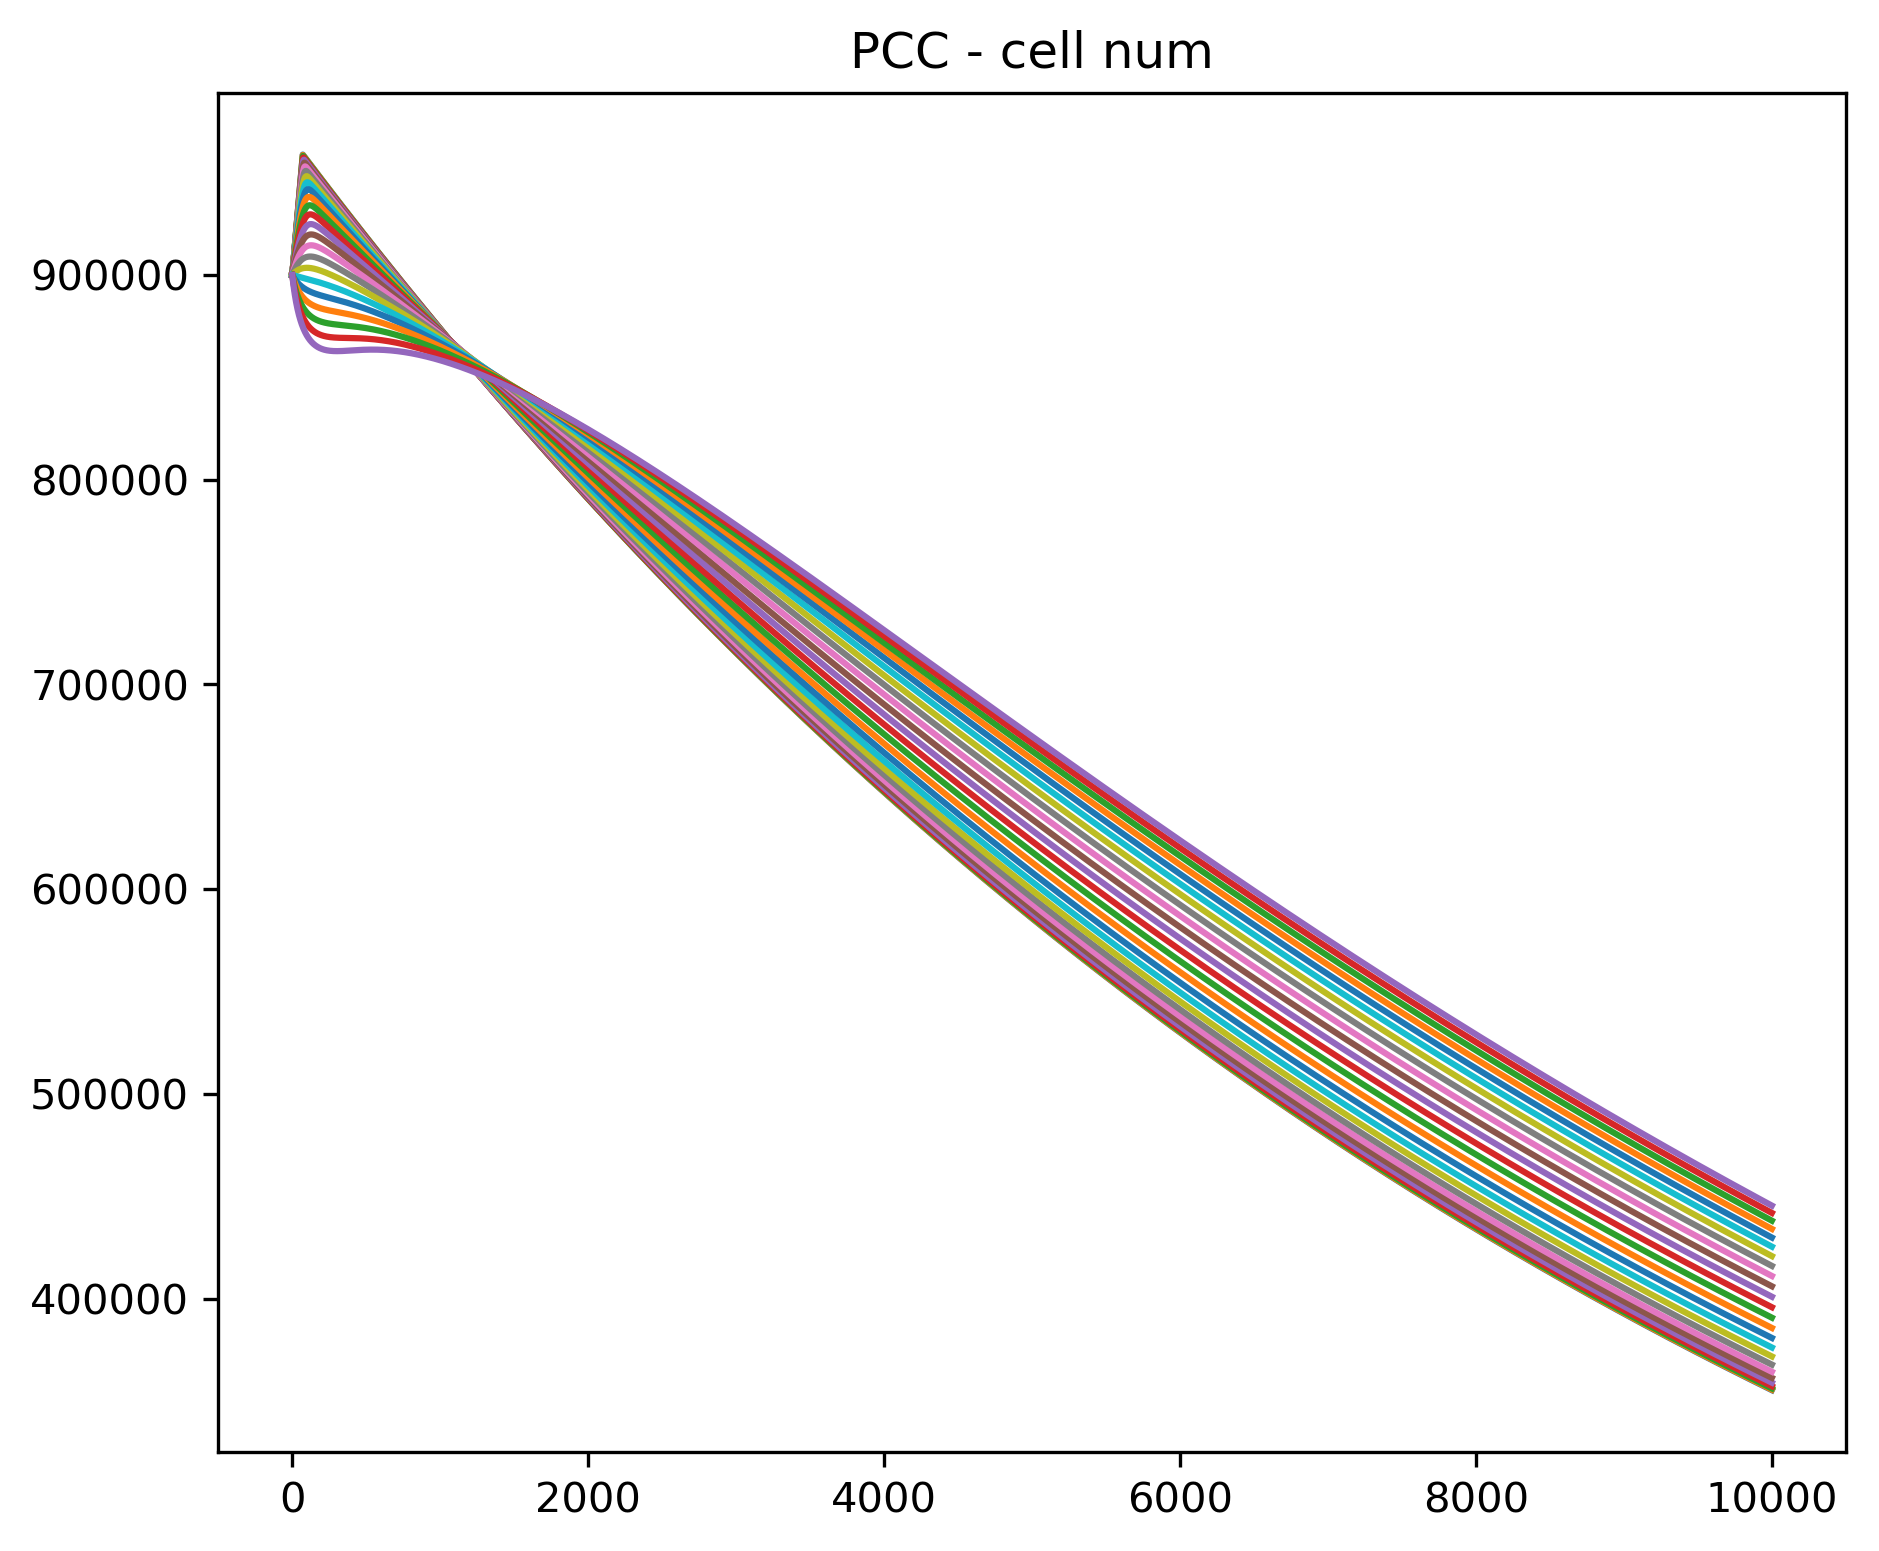

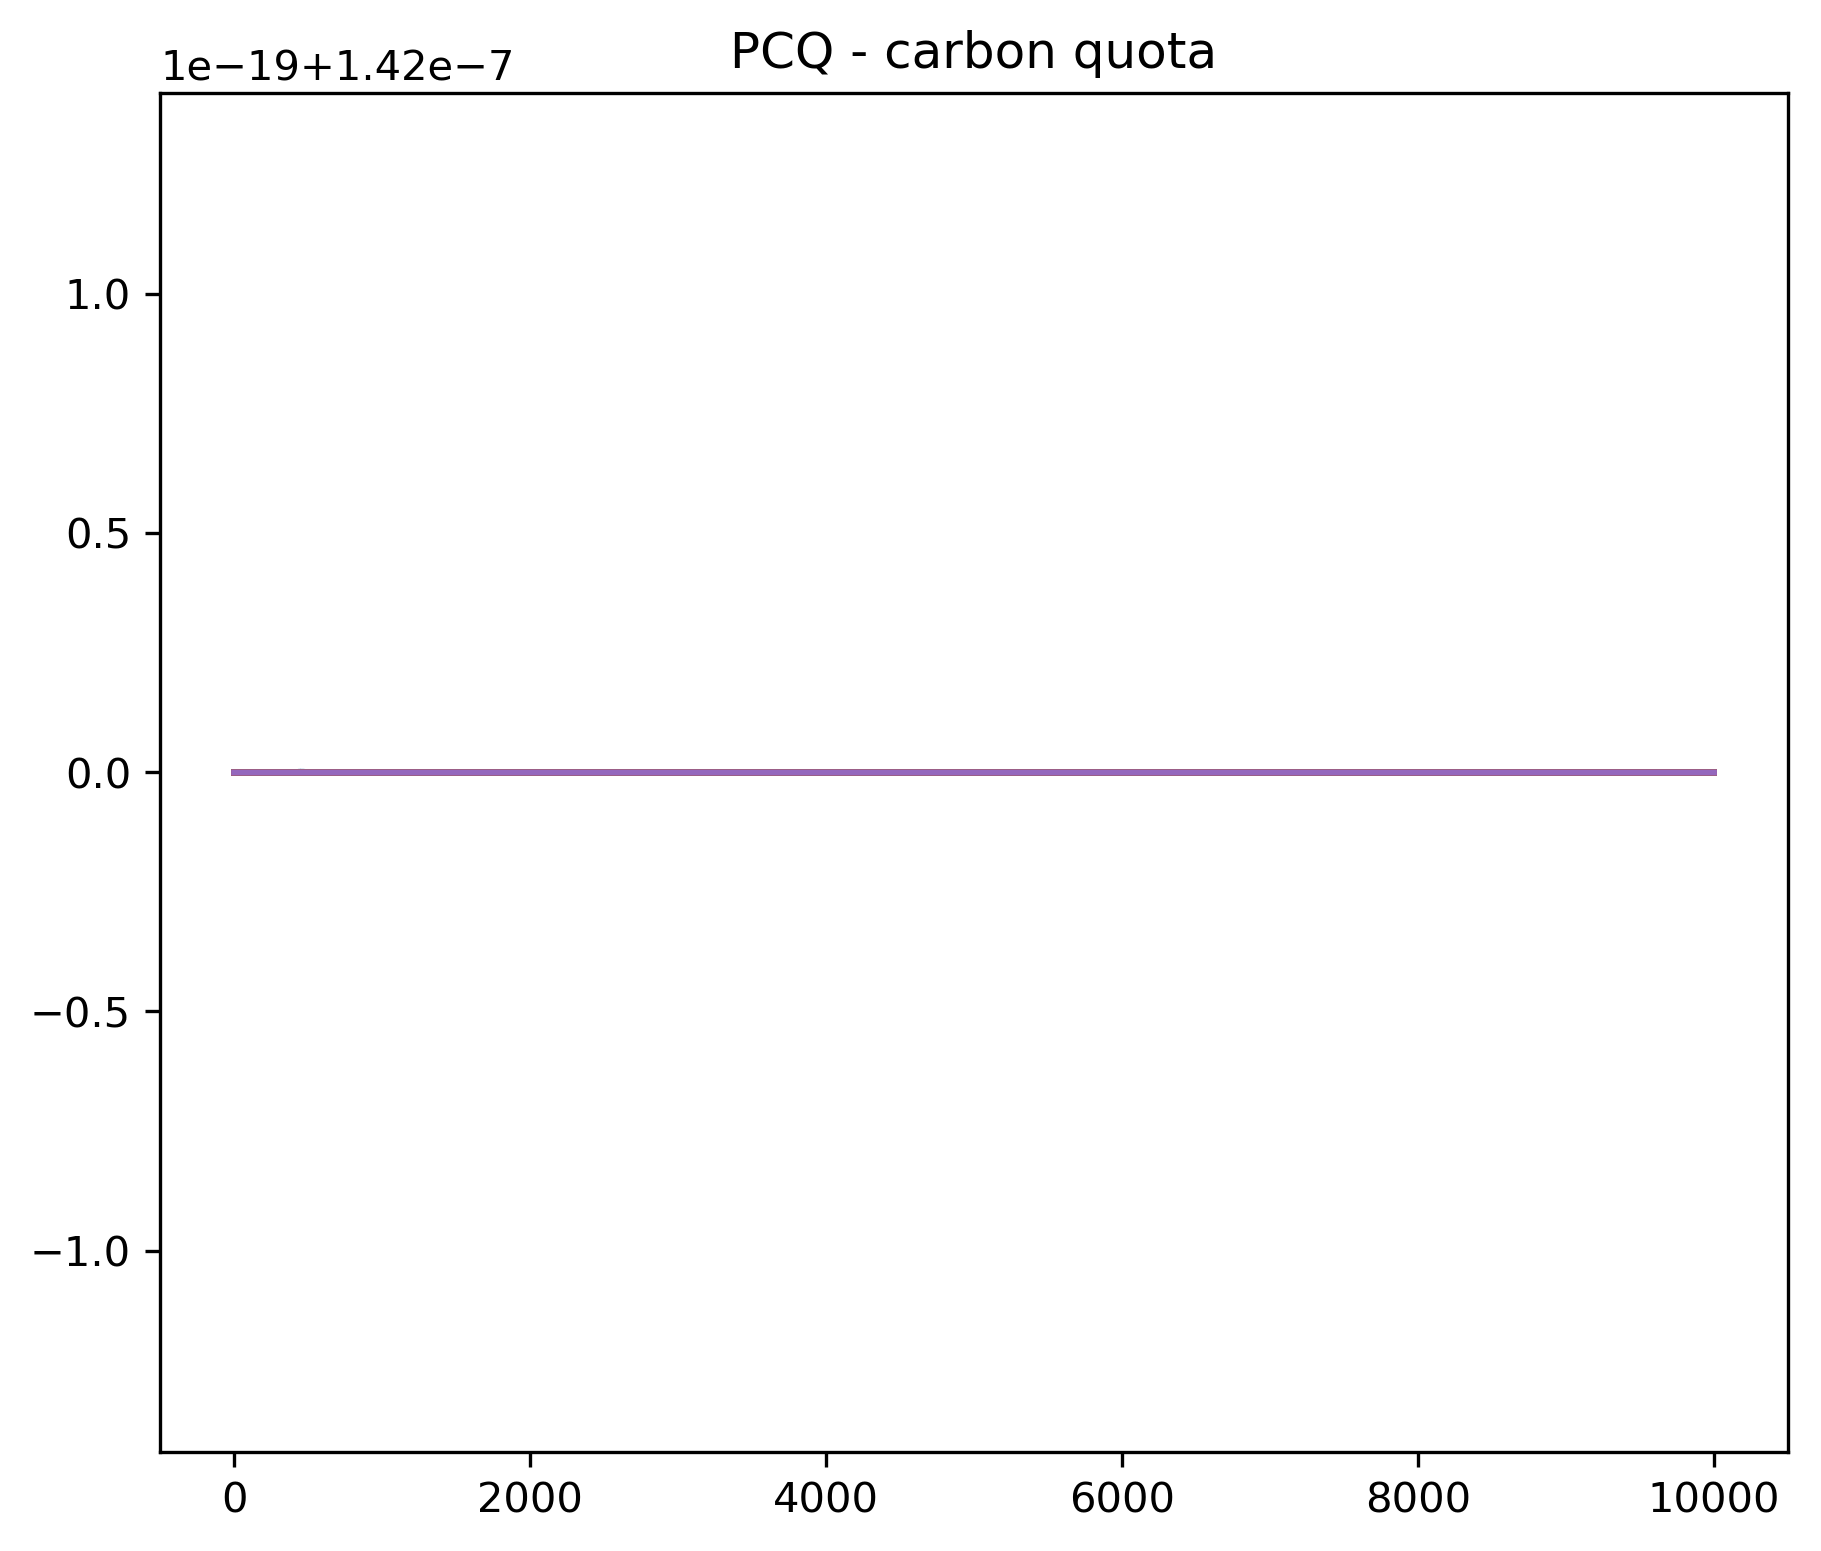

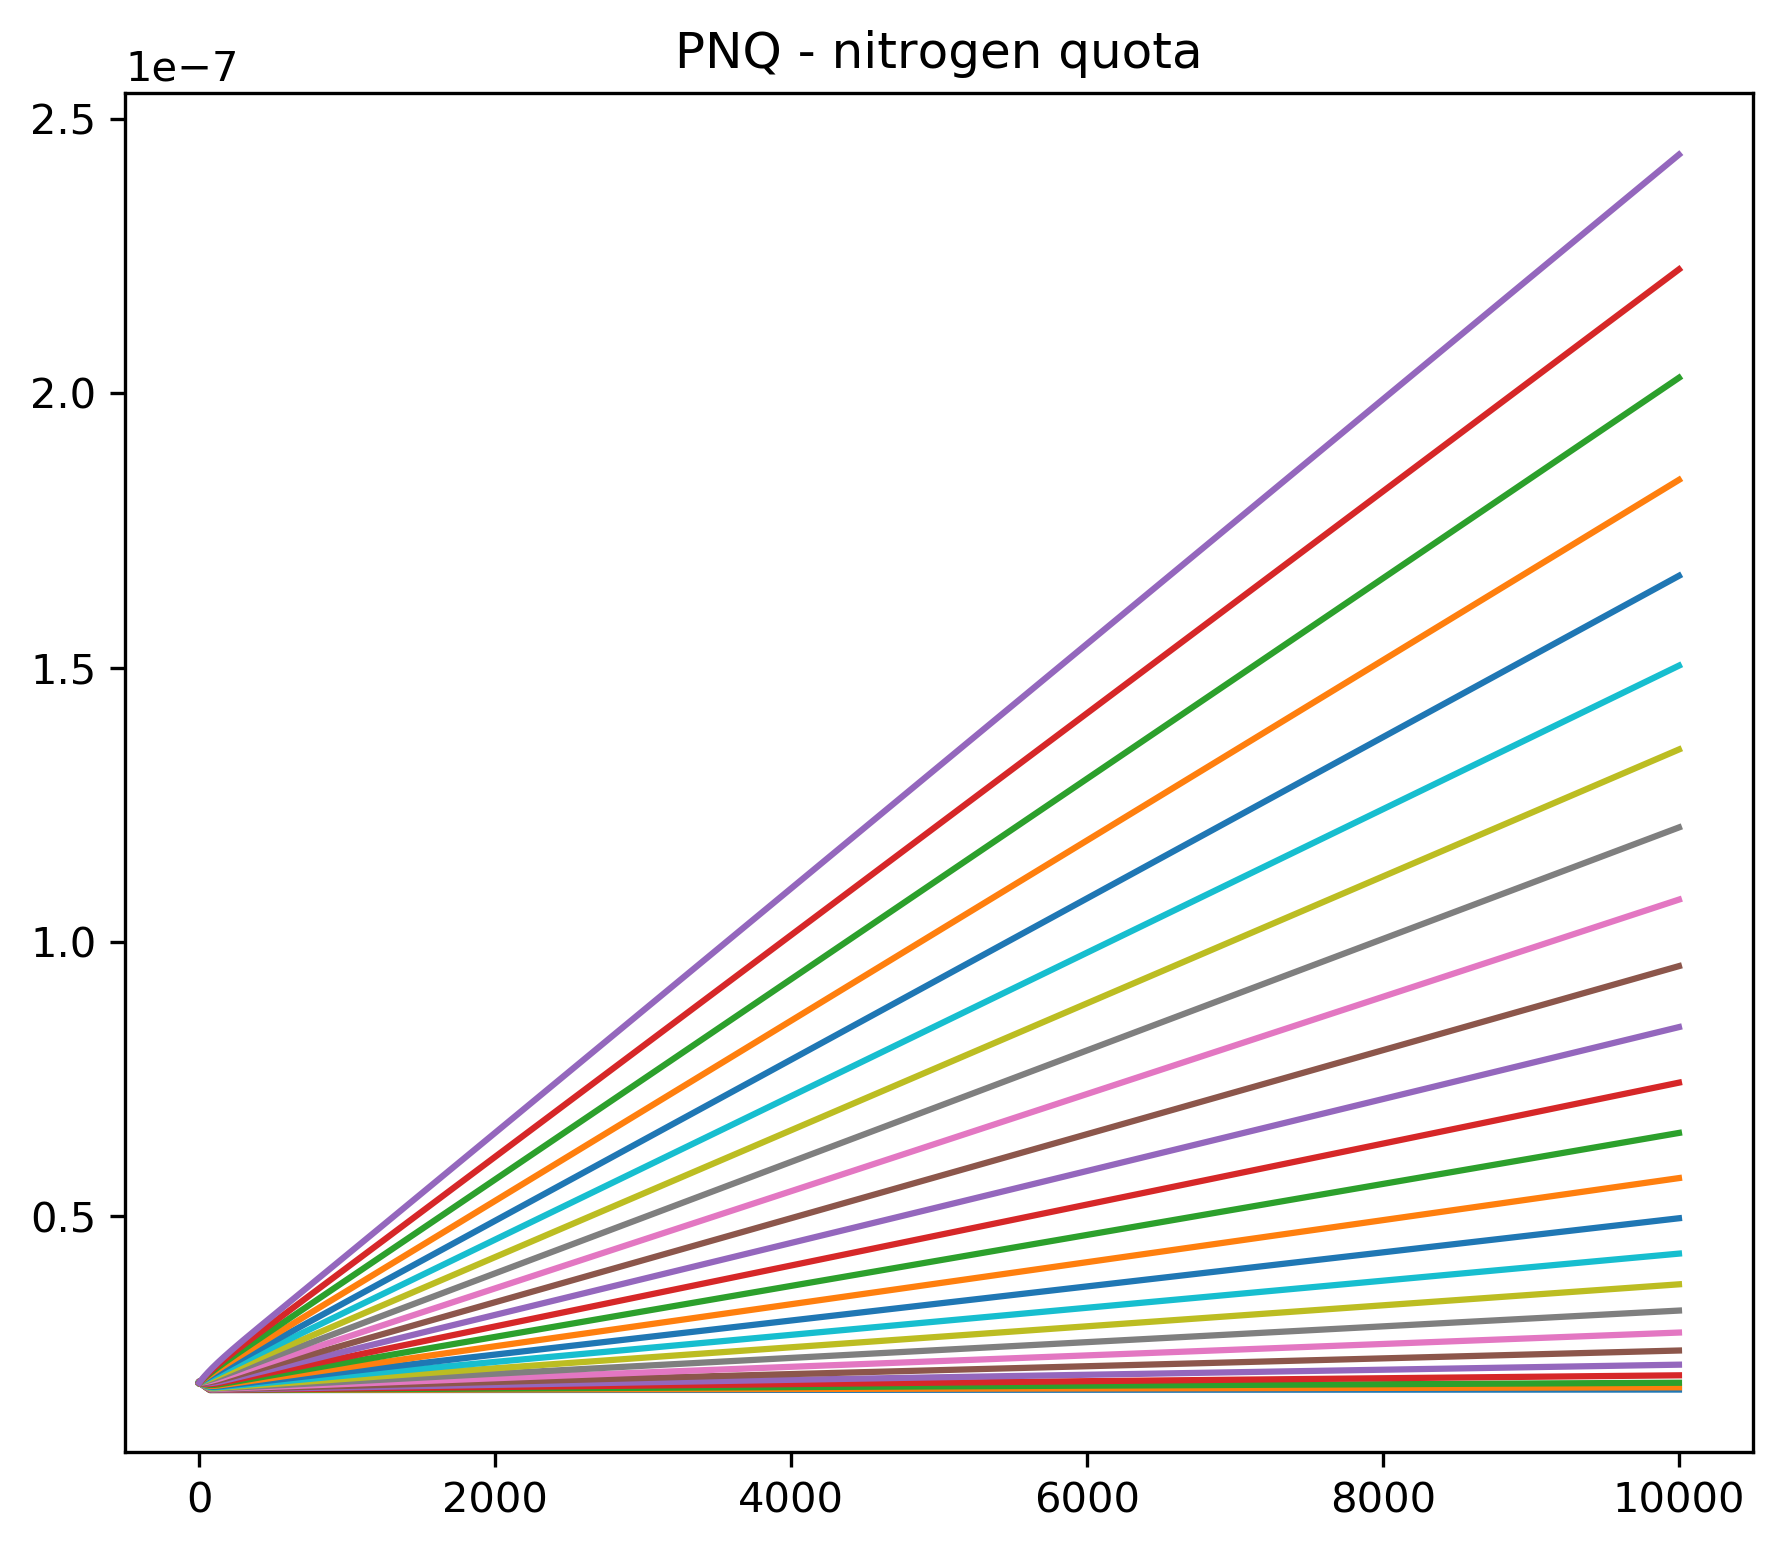

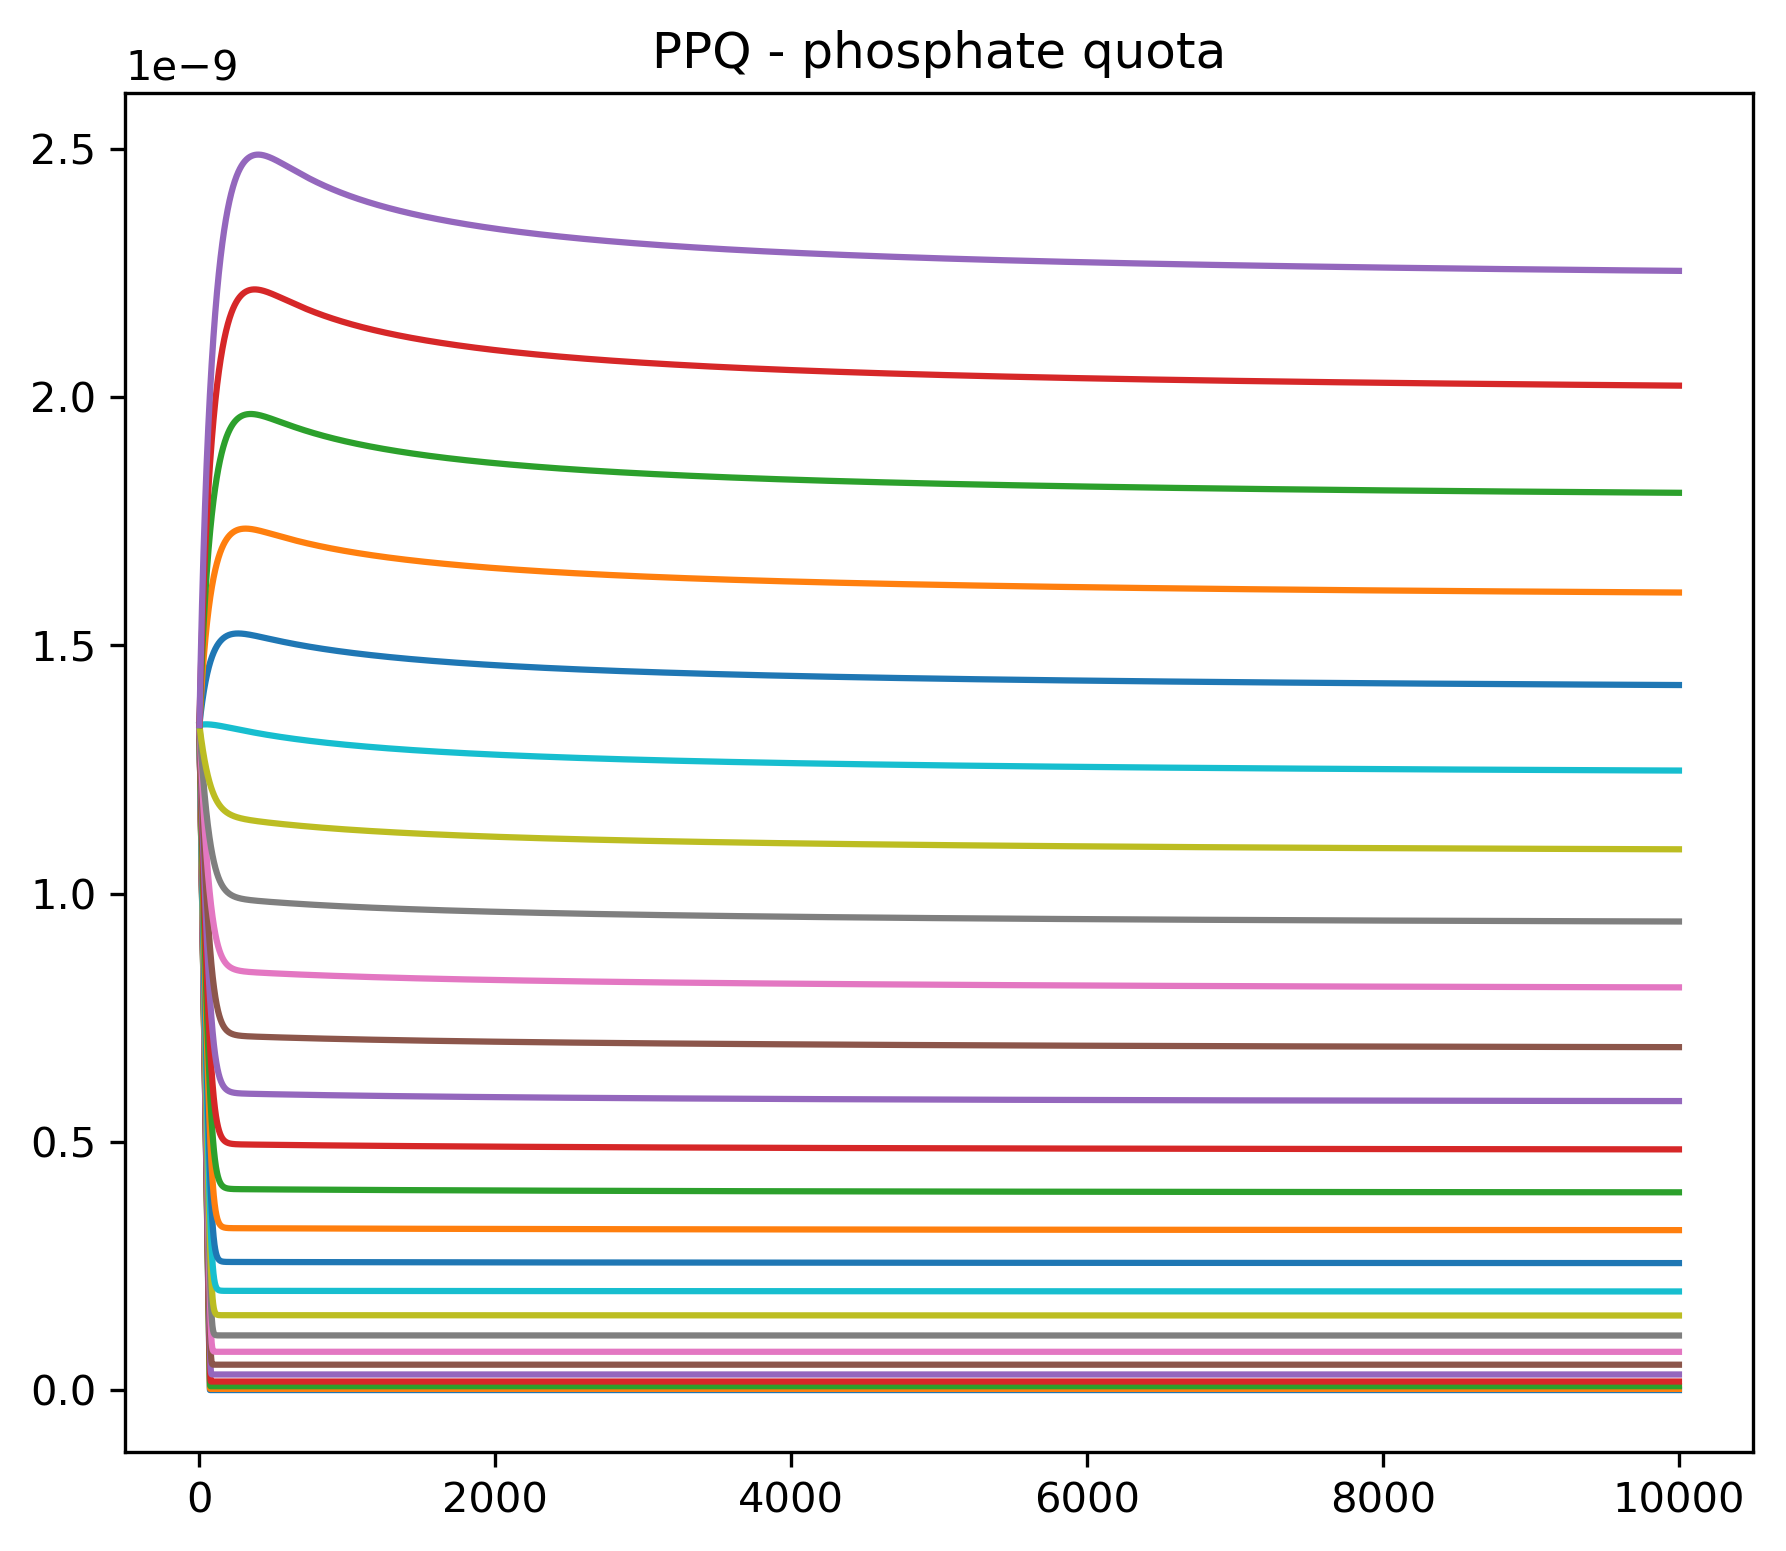

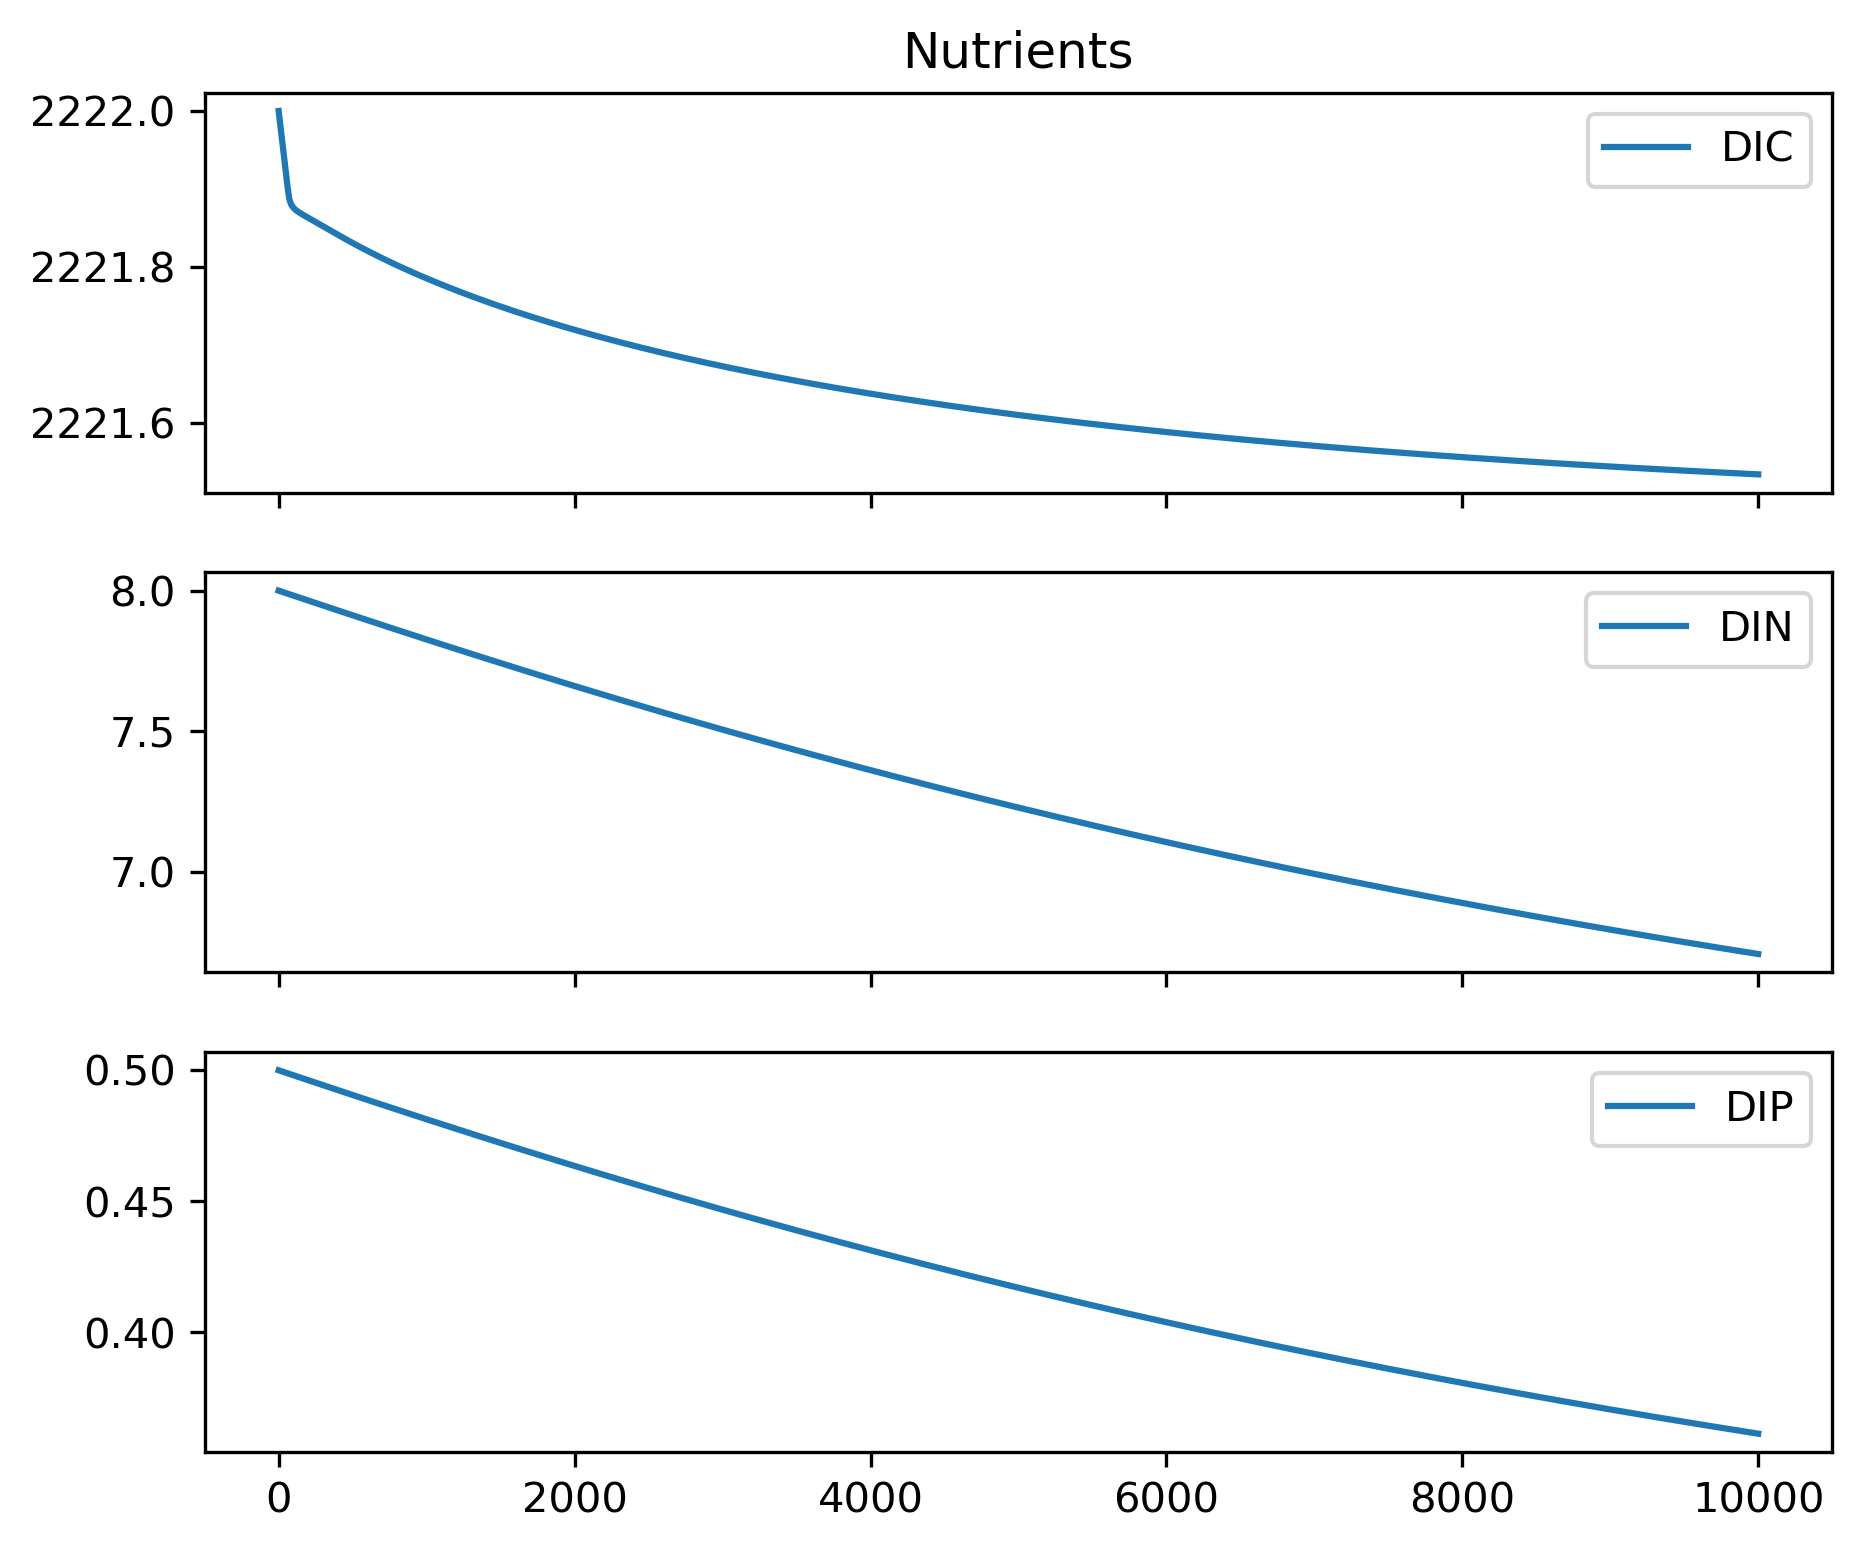

In [10]:
PCC = [sol[:, i] for i in range(numphyto)]
PCQ = [sol[:, numphyto+i] for i in range(numphyto)]
PNQ = [sol[:, numphyto*2+i] for i in range(numphyto)]
PPQ = [sol[:, numphyto*3+ i] for i in range(numphyto)]

DIC = [sol[:, numphyto * 4 ]]
DIN = [sol[:, numphyto * 4 + 1]]
DIP = [sol[:, numphyto * 4 + 2]]

phyt = {'PCC': PCC, 'PCQ':PCQ, 'PNQ':PNQ, 'PPQ':PPQ} 
nuts = {'DIC':DIC, 'DIN':DIN, 'DIP':DIP}

phydat = pd.DataFrame(phyt, dtype='float64')
nutsdat = pd.DataFrame(nuts, dtype='float64')
#phydat['PCC'].plot()

plt.figure(0)
a = [plt.plot(phydat['PCC'][i]) for i in range(numphyto)]
plt.title('PCC - cell num')

plt.show()
b = [plt.plot(phydat['PCQ'][i]) for i in range(numphyto)]
plt.title('PCQ - carbon quota')
plt.show()
c = [plt.plot(phydat['PNQ'][i]) for i in range(numphyto)]
plt.title('PNQ - nitrogen quota')
plt.show()
d = [plt.plot(phydat['PPQ'][i]) for i in range(numphyto)]
plt.title('PPQ - phosphate quota')
plt.show()


fig, phy = plt.subplots(3, sharex=True)

d = [phy[i].plot(nutsdat.loc[0][i]) for i in range(3)]
phy[0].set_title('Nutrients')
phy[0].legend(['DIC'])
phy[1].legend(['DIN'])
phy[2].legend(['DIP'])
plt.show()